<a href="https://colab.research.google.com/github/won-hj/deep_learning_study/blob/main/image_captioning/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 설치

In [1]:
!pip install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --allow-change-held-packages


In [2]:
!pip install -y tensorflow estimator keras


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [3]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

In [4]:
!pip install einops

In [1]:
#통합
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install einops


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libcudnn8
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 446 MB of archives.
After this operation, 1,140 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.6.0.163-1+cuda11.8 [446 MB]
Fetched 446 MB in 16s (28.3 MB/s)
Selecting previously unselected package libcudnn8.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.6.0.163-1+cuda11.8_amd64.deb ...
Unpacking libcudnn8 (8.6.0.163-1+cuda11.8) ...
Setting up libcudnn8 (8.6.0.163-1+cuda11.8) ...
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━

# import

In [2]:
#@title
import concurrent.futures #
import collections
import dataclasses #
import hashlib #
import itertools #
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm #

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

#[선택사항] 데이터처리



## 데이터세트 선택
Flickr8k 또는 Conceptual Captions 데이터세트의 작은 슬라이스 중 하나.
처음부터 다운로드되고 변환되었지만 tensorflow datasets(coco captions 및 전체 conceptual captions)에서 사용할 수 있는 캡션 데이터세트를 사용하기 위해 튜토리얼은 변환하는 것은 어렵지 않음

### **Flickr8k**

#### 압축해제

In [3]:
#압축해제가안됨
import zipfile

def extract_files(path='flickr8k'):
  path = pathlib.Path(path)
  path.mkdir(parents=True, exist_ok=True)


  # Flickr8k_Dataset.zip 압축 해제
  dataset_zip = path / "Flickr8k_Dataset.zip"
  if dataset_zip.exists():
      with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
          zip_ref.extractall(path)

  # Flickr8k_text.zip 압축 해제
  text_zip = path / "Flickr8k_text.zip"
  if text_zip.exists():
      with zipfile.ZipFile(text_zip, 'r') as zip_ref:
          zip_ref.extractall(path)

# 압축 해제 후 파일 목록 확인
#print(list(path.glob("*")))
print()

In [4]:
# 압축해제가 정상적으로 안돼서 해제옵션 False 후 직접 압축해제
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=False) #True
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path, #path
        extract=False) #True

  #압축해제
  extract_files()

  #/content/flickr8k/Flickr8k_text.zip/Flickr8k.token.txt
  #/content/flickr8k/Flicker
  #path = pathlib.Path(path)/'Flickr8k_text.zip'
  #/'Flickr8k_text.zip'
  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  #/'Flickr8k_Dataset.zip'
  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

### **Conceptual Captions**

In [5]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path

    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)

    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

### **데이터세트 다운로드**



Flickr8k는 이미지당 5개의 캡션과 더욱 소규모의 다운로드를 위한 더 많은 데이터 포함

In [6]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

1115419746/1115419746 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
2340801/2340801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


위의 두 데이터세트에 대한 로더는 (image_path, captions)쌍을 포함하는 tf.data.Dataset를 반환함
* Conceptual Captions 는 이미지당 캡션 1개
* Flickr8k 는 이미지당 캡션 5개

In [7]:
train_raw.element_spec #element_spec 어떻게 알지?

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [8]:
for ex_path, ex_captions in train_raw.take(1): #take()
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


## 이미지 특성 추출기

각 이미지에서 특성을 추출하기 위해 이미지모델(imagenet 사전 훈련됨)을 사용함
모델은 이미지분류기로 훈련되었지만, 'include_top=False'는 최종 분류 레이어 없이 모델을 반환하므로 특성 맵의 최종 레이어를 사용할 수 있음

In [9]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True
)
mobilenet.trainable=False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


다음은 모델에 맞게 이미지를 로드하고 크기 조정 하는 함수

In [10]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE[:-1])

  return img

모델은 입력 매치의 각 이미지에 대한 특성 맵 반환

In [11]:
test_img_batch = load_image(ex_path)[tf.newaxis, :] #[] 부분; (128, 128, 3) -> (1, 128, 128, 3) 변경/ : >> 원래차원유지

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


## 텍스트 토크나이저/벡터라이저 설정

[TextVectorization](http://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)레이어를 사용하여 다음 단계에 따라 텍스트 캡션을 정수 시퀀스로 변환

- [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt)를 사용하여 모든 캡션을 반복하고 캡션을 단어로 분할하고 상위 단어의 어휘를 계산
- 각 단어를 어휘의 인덱스에 매핑하여 모든 캡션을 토큰화, 모든 출력 시퀀스의 길이 50
- 단어에서 인덱스로, 인덱스에서 단어로의 메핑을 생성하여 결과 표시

In [12]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['START', s,'END'], separator=' ')
  return s

In [13]:
#use the top 5000 words for a vocab
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True
)
#learn the vocabulary from the caption data

In [14]:
tokenizer.adapt(train_raw.map(lambda fp, txt:txt).unbatch().batch(1024)) #전부

In [15]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', 'START', 'END', 'in', 'the', 'on', 'is', 'and']

In [16]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [17]:
#create mappings for words to indices and indices to words
word_to_index = tf.keras.layers.StringLookup(
    mask_token='', #왜지?
    vocabulary=tokenizer.get_vocabulary()
)
index_to_word = tf.keras.layers.StringLookup(
    mask_token='',
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

In [18]:
w = index_to_word(t)
w.to_list()

[[b'START', b'a', b'cat', b'in', b'a', b'hat', b'END'],
 [b'START', b'a', b'robot', b'dog', b'END']]

In [19]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy() #reduce의 의미???단순 내적이라는건가

array([b'START a cat in a hat END', b'START a robot dog END'],
      dtype=object)

## 데이터세트 준비

'train_raw' 및 'test_raw' 데이터세트는 1:많은 '(image, captions)' 쌍 포함

이 함수는 이미지를 복제하여 캡션에 1:1 매치

In [20]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c') #bc?
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c']
  )
  return images, captions

In [21]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break    #???

print('image path:', ex_paths.shape)
print('captions: ', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image path: (32,)
captions:  (32, 5)

image_paths: (160,)
captions: (160,)


keras 훈련과 호환되려면 데잍터세트느 ㄴ(inputs, labels)쌍을 포함해야함
텍스트생성의 경우 토큰은 한 단계 디종된 입력과 라벨
이 함수는 '(images, texts)'쌍을 '((images, input_tokens), label_tokens)'쌍으로 변환

In [88]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  label_tokens = tf.cast(label_tokens, dtype=tf.int64)
  print(f'label_tokens.dtype: {label_tokens.dtype}')
  return (imgs, input_tokens), label_tokens

#label_tokens.shape: (None, None)



이 함수는 연산을 데이터세트에 추가
1. 이미지 로드(실패이미지무시)
2. 이미지를 복제하여 캡션의 숫자와 매칭
3. 'image, caption' 쌍을 섞고 재배치
4. 텍스트를 토큰화하고 토큰을 이동하여 'label_tokens'을 추가
5. 'RaggedTensor'표현에서 텍스트를 패딩처리된 밀도 높은 'Tensor' 표현으로 변환

In [95]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), tf.cast(out_tok.to_tensor(), dtype=tf.int64)  #out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

모델에 특성 추출기를 설치하고 다음과 같이 데이터세트에서 훈련

In [96]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

label_tokens.dtype: <dtype: 'int64'>


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [97]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

label_tokens.dtype: <dtype: 'int64'>


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## [선택사항] 이미지 특성 캐싱하기


이미지 특성 추출기가 변경되지 않으며 이 튜토리얼은 증강을 사용하지 않아 이미지특성은 캐싱될 수 있음
<!-- 증강하면 이미지 특성 캐싱안되나? -->
텍스트토큰화의경우도 동일

캐시를 설정하는ㄴ데 드는 시간은 훈련 및 검증 중 각 에포크에서 다시 획득

아래의 코드는 두 개의 함수인 'save_dataset' 및 'load_dataset' 정의

In [98]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds


In [99]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

label_tokens.dtype: <dtype: 'int64'>


188it [00:51,  3.64it/s]


label_tokens.dtype: <dtype: 'int64'>


32it [00:10,  3.07it/s]


# 훈련을 위한 데이터 준비

이러한 사전 처리 단계 후, 데이터세트는 다음과 같음

In [100]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [101]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

데이터세트는 keras 훈련에 적합한 (input, label) 쌍 반환

inputs 은 (images, input_tokens) 쌍
images 는 특성추출기 모델로 처리됨
input_tokens 의 각 위치의 경우 모델은 지금까지의 텍스트를 보고 labels의 같은 위치에서 나열된 다음 텍스트 예측 시도

In [127]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

  print(ex_img.shape, ex_img.dtype)
  print(ex_in_tok.shape, ex_in_tok.dtype)
  print(ex_labels.shape, ex_labels.dtype)

(32, 7, 7, 576) <dtype: 'float32'>
(32, 21) <dtype: 'int64'>
(32, 21) <dtype: 'int64'>


입력 토큰 및 라벨은 동일하며, 다음과 같이 한 단계민 이동

In [103]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  17   8 795   2 134  37   2 394 105   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[  2  17   8 795   2 134  37   2 394 105   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


# 트랜스포머 디코더 모델

이 모델은 사전 훈련된 이미지 인코더가 충분하다고 가정하며 텍스트 디코더를 빌드하는데만 집중
이 튜토리얼은 2단 레이어 트랜스포머디코더사용
<!-- 사전 훈련 이미지 인코더가 충분하지 않다면? 사전 훈련 이미지 인코더를 빌드하는데 집중하려면? 2단 레이어 트랜스포머디코더를 사용하지 않는다면? -->

이 구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)의 구현과 거의 동일

<table>
<tr>
<th> 트랜스포머 인코더 및 디코더 </th>
</tr>
<tr>
<td> <img width='400' src='https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png'>
</td>
</tr>
</table>

1. 입력 - 토큰 임베딩 및 위치 인코딩 (seqembedding)
2. 디코더 - 각 다음을 포함하는 트랜스포머 디코더 레이어(decoderlayer)의 스택
    1. 추후 각 출력 위치가 지금까지 출력에 대해 처리할 수 있는 인과적 셀프어텐션(`causalselfattention`)
    2. 각 출력 위치가 입력 이미지를 추리할 수 있는 크로스 어텐션 레이어 (`crossattention`)
    3. 각 출력 위치를 독립적으로 추가로 처리하는 피드 포워드 네트워크 (`feedforward`)레이어
3. 출력 - 출력 어휘에 대한 멀티 클래스 분류

## 입력

입력 텍스트는 이미 토큰으로 분할되고 id 시퀀스로 변환되었음
CNN 또는 RNN과 다르게 트랜스포머의 어텐션 레이어는 시퀀스의 순서에 대해 변하지 않음
몇몇 위치 입력이 없다면 시퀀스가 아닌 세트만 봄
따라서 각 토큰 ID에 대한 단순 벡터 임베딩 외 임베딩 레이어는 시퀀스 내 각 위치에 대한 임베딩도 포함

`SeqEmbedding` 레이어는 다음과 같이 정의
* 각 토큰에 대한 임베딩 벡터 검색
* 각 시퀀스 위치에 대한 임베딩 벡터 검색
* 두 개 모두 합함
* `mask_zero=True`를 이용하여 모델에 대한 keras 마스크 초기화

참고: 이 구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)에서와 같이 고정된 임베딩을 사용하는 대신 위치 임베딩을 학습합니다. 임베딩을 학습하는 것은 코드가 약간 적지만 더 긴 시퀀스로 일반화되지는 않습니다.

In [104]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

## 디코더

디코더는 표준 트랜스포머 디코더로, 각 세 개의 하위 레이어인 `CausalSelfAttention`, `CrossAttention` 및 `FeedForward`를 포함하는 `DecoderLayers`의 스택을 포함

구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)과 거의 동일하며, 자세한 내용은 이를 참조하세요.
<br>


다음은 `CausalSelfAttention`레이어

In [105]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

아래는 `CrossAttention`레이어

`return_attention_scores` 사용하는 데 유의

In [106]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

아래는 `FeedFoward` 레이어
`layers.Dense`레이어는 입력의 최종 축에 적용된다는 점 기억
<!-- 입력의 최종 축? -->
입력의 형태는 `(batch, sequence, channels)`이므로 `batch` 및 `sequence` 푹에 걸쳐 포인트별로 자동으로 적용

In [107]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

다음으로 이러한 세 가지 레이어를 더 큰 규모의 `DecoderLayer`에 배열
각 디코더 레이어는 시퀀스에 세 개의 더 작은 레이어 적용

각 하위 레이어 다음의 `outt_seq`형태는 `(batch, sequence, channels)`

디코더 레이어는 추후 시각화를 위한 `attention_scores`반환

In [108]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq


## 출력

출력 레이어는 각 위치에서 각 토큰에 대한 로짓 예측을 생성하려면 최소한 `layers.Dense`레이어가 필요

하지만 이 작업을 좀 더 잘 수행할 수 있도록 추가할 수 있는 몇가지 다른 특성
1. **잘못된 토큰 처리**: 모델은 텍스트를 생성합니다. 패딩, 알 수 없는 또는 시작 토큰(`''`, `'[UNK]'`, '[START]'`)을 생성해서는 안됩니다.  따라서 이들에 대한 편향을 큰 음수값으로 설정합니다
<!-- 왜? 음수값을 크게하면?? -->
    > 참고: 손실 함수의 이러한 토큰 역시 무시해야 합니다.

2. **스마트 초기화**: 밀도가 높은 레이어의 기본 초기화는 거의 균일한 확률로 각 토큰을 초기에 예측하는 모델을 제공합니다. 실제 토큰 분포는 균일한 것와는 거리가 멉니다. 출력 레이어의 초기 편향을 위한 최적값은 각 토큰의 확률 로그입니다. 이는 균일한 분포 (`log(vocalbulary_size)`)의 엔트로피로부터의 분포의 한계 엔트로피(`'-p*log(p)'`)로 초기 손실을 줄입니다.

In [109]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      if token in vocab_dict:
        counts_arr[vocab_dict[token]] = 0 #error '[START]'

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


스마트 초기화는 초기 손실을 다음과 같이 상당히 줄임

In [110]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:13<00:00, 71.22it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


## 모델 빌드하기

모델을 빌드하려면 몇몇 부분을 조합
1. 이미지 `feature_extractor` 및 텍스트 `tokenizer`
2. 토큰 ID의 배치를 벡트 `(batch, sequence, channels)`로 변환하기 위한 `seq_embedding`레이어
3. 텍스트 및 이미지 데이터를 처리할 `DecoderLayers`레이어의 스택
4. 다음 단어가 무엇이어야 하는지에 대한 포인트별 예측을 반환하는 `output_layer`

In [111]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer


훈련을 위해 모델을 호출하면 `image, txt`쌍을 수신
이 함수를 더 유용하게 하려면

 * 이미지에 3개의 채널이 있다면 feature_extrator를 통해 실행, 그렇지 않으면 이미 실행된 것으로 가정
 * 텍스트에 dtype `tf.string`이 있다면 토크나이저를 통해 실행

그런 다음 모델을 실행하는 것은 몇 단계만 수행하면 됨
1. 추출된 이미지 특성을 평면화하여 디코더 레이어에 대한 입력이 될 수 있도록 함
2. 토큰 임베딩 검색
3. 이미지 특성 및 텍스트 임베딩에서 `DecoderLayer`의 스택 실행
4. 출력 레이어를 실행하여 각 위치에서 다음 토큰을 예측

In [112]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [113]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

## 캡션 생성하기

훈련을 시작하기 전에, 코드를 약간 작성해 캡션을 생성
이를 사용하여 훈련이 어떻게 진행되는지 확인

다음과 같이 테스트 이미지 다운로드하여 시작

In [114]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

이 모델로 이미지를 캡션하려면 다음을 수행

* `img_features`추출
* `[START]` 토큰으로 출력 토큰 목록 초기화
* `img_features` 및 `tokens`를 보델로 전달

    * 이는 로짓 목록 반환
    * 이로한 로짓을 기반으로 다음 토큰 선택
    * 토큰 목록에 이를 추가하고 루프 계속
    * `'[END]'` 토큰이 생성되었다면 루프 탈출

이를 위해 간단한 메서드 추가

In [115]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

다음은 모델의 훈련되지 않은, 해당 이미지를 위해 생성된 일부 캡션으로 아직 의미가 그다지 없음

In [116]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


a a END a END a END a END END END END a END END a END END a a END END END a a END a END a END a END END END a a a END END END END END END a END END END a END
the a END in END man is a in END END a a END a END END a a END END camera in a END END down a white a the on a child a a grass END END END a END END the a a a END END
at young in are a the filled a the from END parachute volleyball snowman in lake of in shirt dog a on dog motorcyclist first pylon END END ball a glasses bowl bikes is in white leaf people through jumps cellphone face END face fish restaurant END a a


온도 매개변수를 통해 다음 세 모드 사이에 삽입 가능
1. 그리디 디코딩(`temperature=0.0`) - 각 단계에서 가장 확률이 높은 다음 토큰 선택
2. 로짓(`temperature=1.0`)에 따른 랜덤 샘플링
3. 균일 랜덤 샘플링(`temperature >> 1.0`)

모델이 훈련되지 않았고 빈도 기반 초기화를 사용하였으므로 '그리디'출력은 (우선)일반적으로 가장 일반적인 토큰인 `['a', '.', '[END]']` 만 포함

# 훈련

모델을 훈련하려면 몇몇 추가 컴포넌트 필요
* 손실 및 메트릭
* 옵티마이저
* 선택적 콜백

## 손실 및 메트릭

다음은 마스킹 된 손실 및 정확성에 대한 구현
손실에 대한 마스크 계산 시 `loss < 1e8` 주의
이 항은 `banned_tokens`에 대한 인적이고 불가능할 정도로 높은 손실을 버림
<!-- 무슨 의미? -->

In [129]:
# labels를 loss에서도 cast하는걸 추가했는데 이전에 따로 cast했던 것들 중 어떤거만 하면 되는지는 아직 모르곘음 (시간상전부돌리기엔자원부족)
def masked_loss(labels, preds):
  labels = tf.cast(labels, tf.int64)
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

## 콜백

훈련 중 피드백을 위해 `keras.callbacks.Callback`을 설정해 각 epoch의 끝에 서퍼 이미지에 대한 일부 캡션 생성

In [118]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

  @property
  def model(self):
    return self._model
  @model.setter
  def model(self, value):
    # You can add validation here if needed
    if not isinstance(value, tf.keras.Model): # Example validation
        raise TypeError("Model must be a tf.keras.Model instance")
    self._model = value


이는 첫 번째가 '그리디'인 이전과 같은 이전 예시와 같은 세 개의 출력 문자열을 생성하여 각 단계에서 로짓의 argmax 선택

In [119]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a END a END a END a END END END END a END END a END END a a END END END a a END a END a END a END END END a a a END END END END END END a END END END a END
in a END a in END END a END a red END a END in a a on a on boy END a on and a a END in END the a the END three is the a END END END of a END a a in END on
steel and rainbow backs swims two children END and players grass END chews dog the the car rodeo runs a to a crowd sitting sleds dogs down END a END tennis END thrown a two a and playing water young woman purple toy of boat racket on running ladies



또한 `callbacks.EarlyStopping`을 사용하여 모델 과적합 방지

In [120]:
callbacks =[
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

## 훈련

훈련을 구성하고 실행

In [131]:
#컴파일먼저 하고 fit 실행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=masked_loss, metrics=[masked_acc])

빈도 보고를 더 많이 하려면, `Dataset.repeat()`메서드 사용, `steps_per_epoch`및`validation_steps`인수를 `Model.fit`으로 설정
`Flicker8k`에서 이러한 설정을 통해 데이터세트에 대한 전체 전달은 배치가 900개 이상이지만
보고-epoch 아래에는 100 단계가 있음
<!-- ???? -->

In [132]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.0725 - masked_acc: 0.1847



/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a man in a man in the water END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END
a man on a ball END END END in a man END END END END on a holding END END in a END END END END END END END END END END END END END END END END END END in the is END END END in a white
grass END front in rollerblades on slip with the dirt END END on sit END END in the lot in man green in blonde END END water fingers END little ball different woman END climbing with woman water END some concrete END END END END END in carved out

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - loss: 5.0707 - masked_acc: 0.1850 - val_loss: 4.5031 - val_masked_acc: 0.2577
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.4812 - masked_acc: 0.2723

a man in a red in the water END END END END END END END END END END END END END END END END END END END END in the water END END END in a water END END END END E

훈련 실행 동안의 손실 및 정확성 플롯:

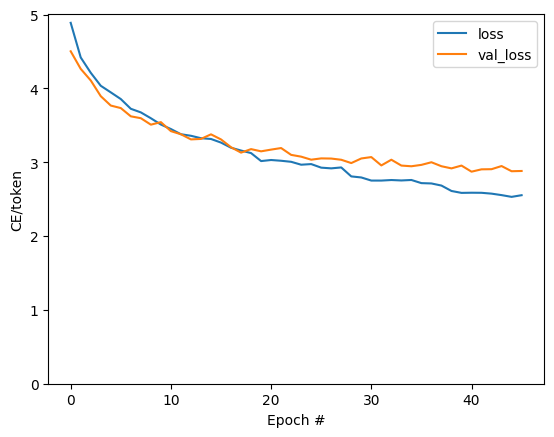

In [134]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

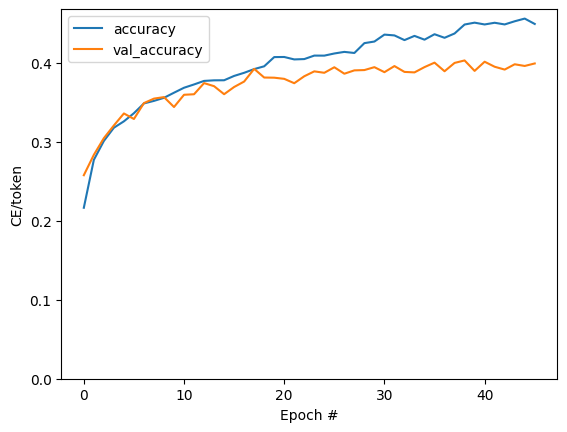

In [135]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

#  어텐션 플롯

훈련된 모델을 사용하여 이미지에서 해당 `simple_gen`메서드 실행

In [137]:
result = model.simple_gen(image, temperature=0.0)
result

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


'a man in a red wetsuit is surfing END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END END'

출력을 토큰으로 다시 분할

In [138]:
str_tokens = result.split()
str_tokens.append('[END]')

각 `DecoderLayers`는 `CrossAttention`레이어에 대한 어텐션 스코어를 캐싱
각 어텐션 맵의 형태는 `(batch=1, heads, sequence, image)`

In [141]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 50, 49]), TensorShape([1, 2, 50, 49])]

따라서 `image`축을 `height, width`로 다시 분할하는 한편 `batch`축을 따라 맵을 스택한 다음 `(batch, heads)`축에 대해 평균을 냄

In [167]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height =7, width =7, #height=7 안되는데 height =7은 된다
    reduction='mean')

각 시퀀스 예측을 위한 단일 어텐션 맵이 하나 존재

각 맵의 값은 합계가 1

In [168]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 1.        , 1.        ],
      dtype=float32)>

따라서 다음은 출력에 대한 각 토큰을 생성하는 동안 모델이 어텐션에 주목

In [187]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      #print(f'map: {map.shape}')
      grid_size = max(int(np.ceil(len_result/2)), 2)
      #grid_size = int(np.ceil(len_result / 2))  # max() 없이 테스트
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, #extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()
    #plt.subplots_adjust(hspace=0.5, wspace=0.5)

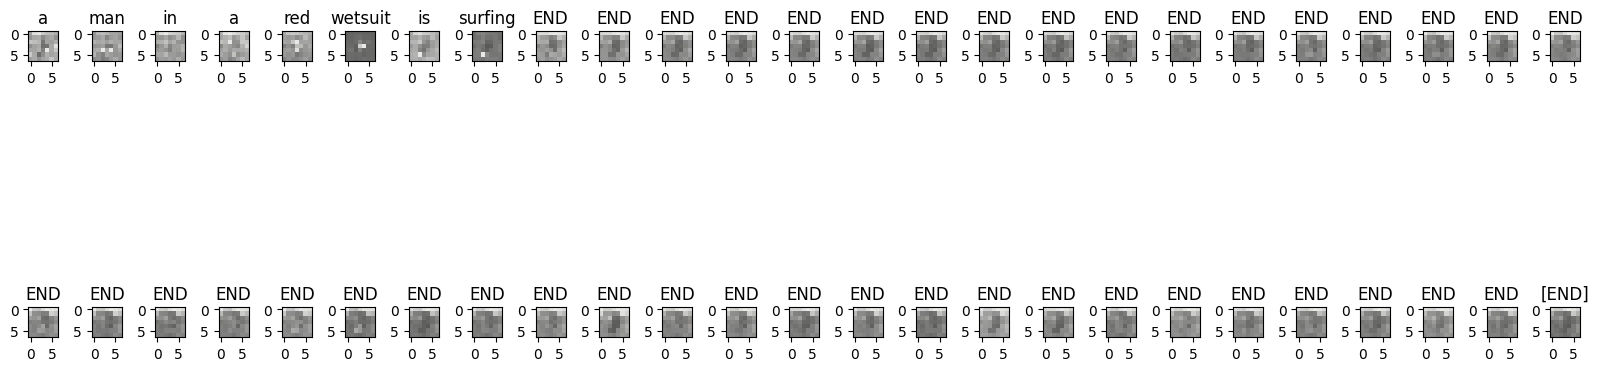

In [188]:
plot_attention_maps(image/255, str_tokens, attention_maps)

더 유용한 함수로 함께 통합

In [171]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height =7, width =7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

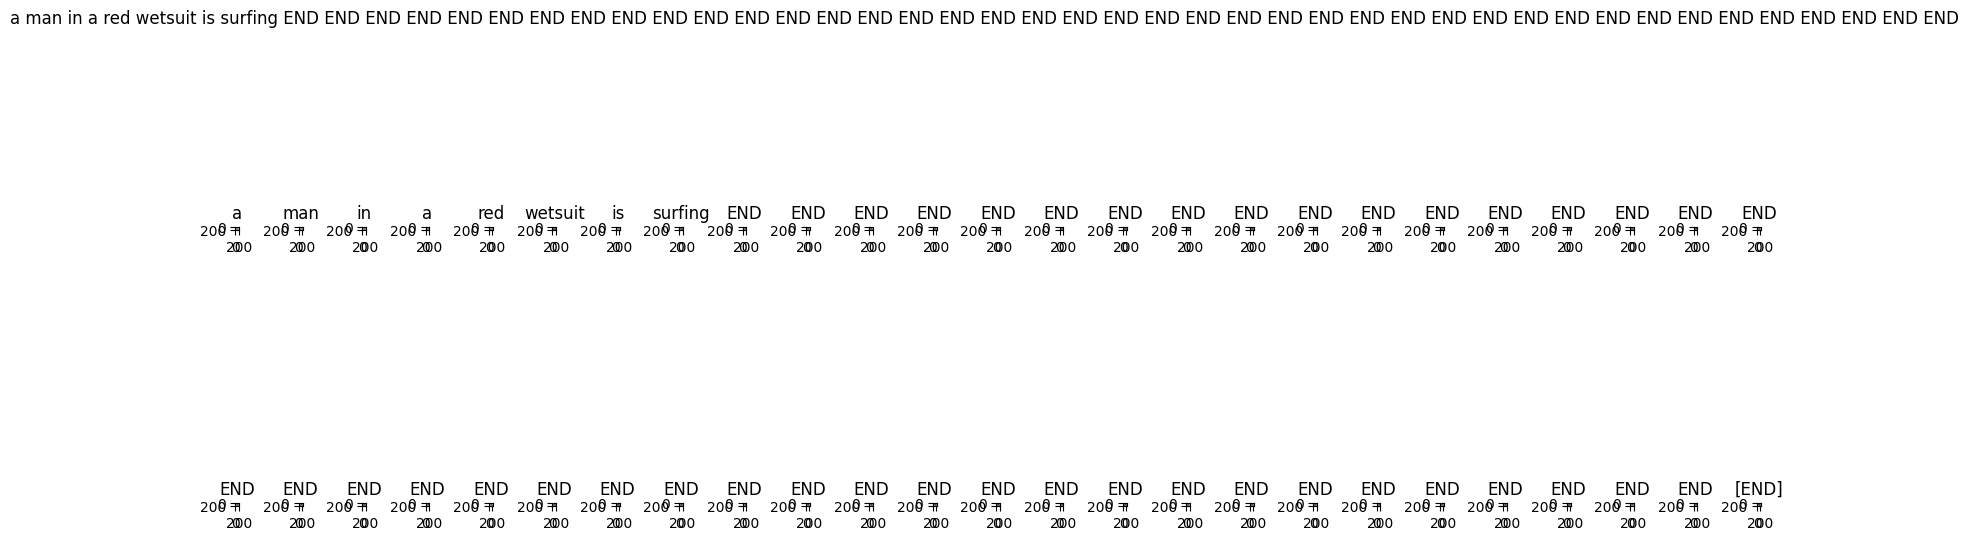

In [172]:
run_and_show_attention(model, image)

## 자체 이미지로 시도해보기

재미를 위해 방금 훈련한 모델로 자체 이미지를 캡션하는 데 사용할 수 있는 방법을 제공했습니다. 상대적으로 적은 양의 데이터로 훈련되었으므로 이미지가 훈련 데이터와 다를 수 있습니다(결과가 이상할 수 있습니다!).


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


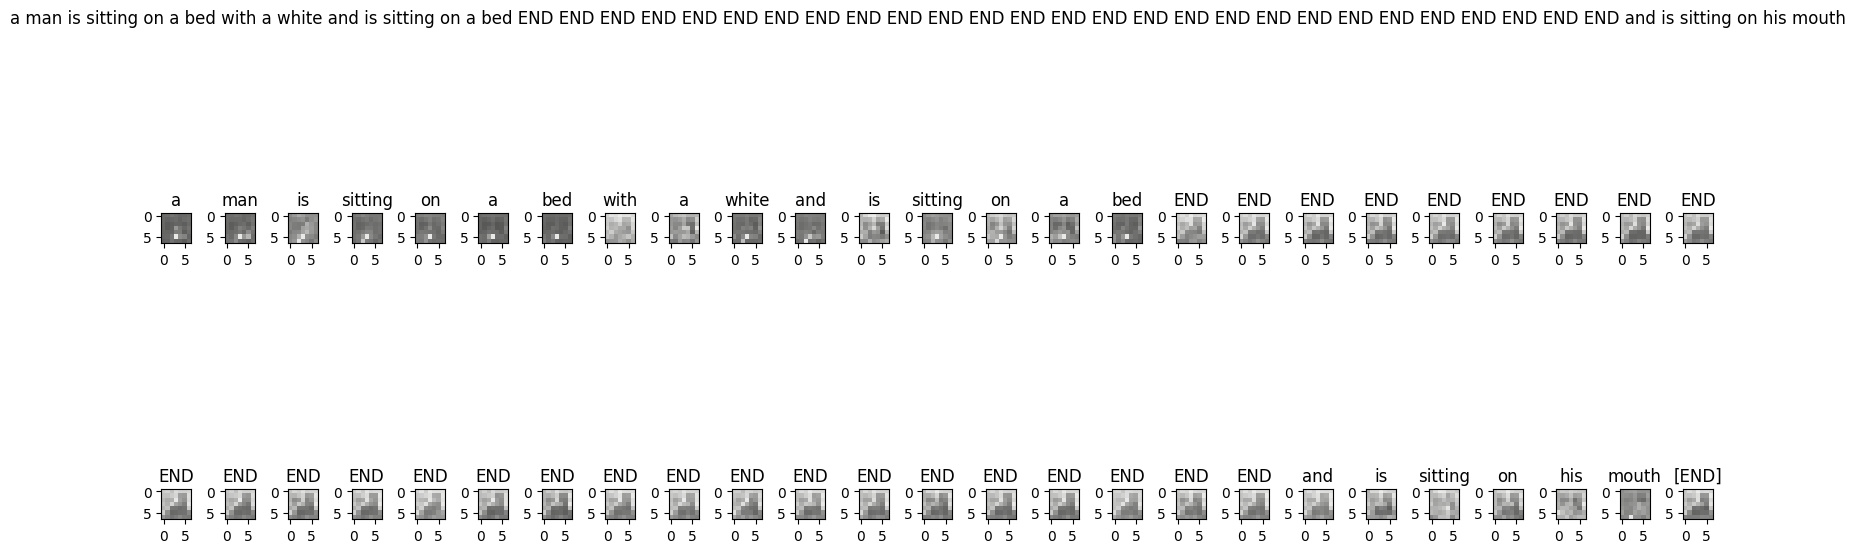

In [189]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)